# Anomaly Detection in credit card transactions using unsupevised methods

The goal of this exercise is to detect anomalous events in clients credit card transactions dataset.

For this task, the dataset used contains 14216 transactions out of which 39 are frauds, accounting for 0.27% of the data. There are 28 features available for the task, representing a fraction of a much higher number of features in the original dataset. 
The features are labeled V1, V2..., V28 and are the result of apply PCA to the original higher dimensional feature space, in order to preserve the confidentiality of the clients.

The label for each transaction is 0 for nominal and 1 for anomaly.



The data used in this exercise is a tiny fraction of a much larger dataset from the Kaggle competition website. More details about the complete dataset can be found on Kaggle at https://www.kaggle.com/mlg-ulb/creditcardfraud

In [26]:
#Load the needed libraries

import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.manifold import TSNE

Import the data

In [17]:
data = pd.read_csv("fraud_detection_data1.csv")
data.head()

,Unnamed: 0,Time,V1,V2,V3,V4,V5,V6,V7,V8,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,106066,69808.0,0.136174,-1.647766,0.850033,1.576178,-1.569057,-0.106752,0.026632,-0.091738,...,0.584649,0.582371,-0.548530,0.456719,0.202315,-0.314320,-0.018220,0.138062,540.00,0
1,102005,68015.0,-0.911610,0.680815,1.344329,-0.068517,0.596394,-1.268838,0.769226,-0.134888,...,0.139301,0.252879,-0.228605,0.360421,0.043382,-0.588531,-0.026174,0.159864,6.89,0
2,278450,168231.0,-0.917299,0.860942,1.201170,-0.962314,-0.372495,-0.114847,0.001741,0.699885,...,-0.138630,-0.493530,0.001530,-0.370406,-0.392434,0.304997,0.177416,0.115137,19.99,0
3,120218,75751.0,1.252596,0.021359,0.044063,0.325909,0.011174,-0.053598,-0.097035,0.013237,...,-0.096153,-0.266459,-0.071237,-0.749998,0.389529,0.494047,-0.029793,0.002433,17.80,0
4,258527,158694.0,-1.109483,1.061341,1.484072,0.923891,-0.137718,0.816640,0.014252,0.938303,...,-0.479951,-1.369632,-0.020618,0.578319,0.329709,-0.825568,0.209439,0.068794,24.48,0


In [18]:
print(len(data.loc[data['Class']==0]))
print(len(data.loc[data['Class']==1]))

14216
39


Visualize the class distribution of the data

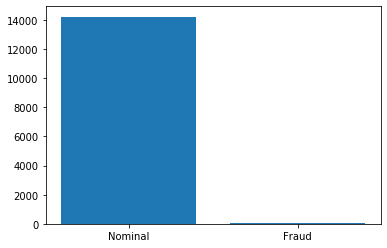

In [19]:
_, counts = np.unique(np.array(data['Class']), return_counts=True)
labels = ["Nominal", "Fraud"]
plt.bar(labels, counts, align='center')
plt.gca().set_xticks(labels)
plt.show()

As we can see the dataset is very imbalanced and doesn't have enough negative example to train a regular classifier to separate nominal and anomalies. 
Unsupervised learning approaches have shown to perform better in this kind of situation.

In [23]:
# Split the label from the features
true_label = data['Class']
data.drop('Class',1, inplace=True)

Exploration of both normal and fraud data

Normal transactions: 

count    14216.000000
mean        91.260075
std        251.280760
min          0.000000
25%          5.990000
50%         22.215000
75%         76.052500
max       7583.320000
Name: Amount, dtype: float64

 ----------------------------------------------------------- 

Fraud transactions: 

count     39.000000
mean      37.666154
std       78.996187
min        0.000000
25%        1.000000
50%        7.520000
75%       42.740000
max      444.170000
Name: Amount, dtype: float64




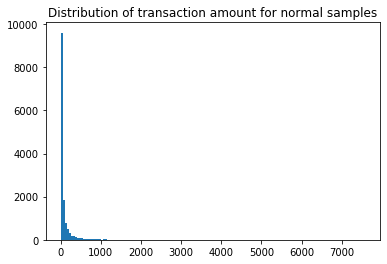

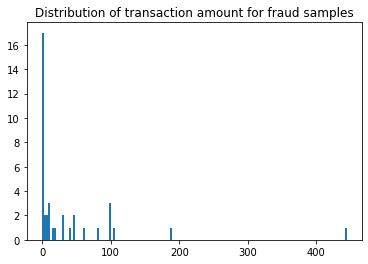

In [20]:
nominal_samples = data.loc[data['Class']==0]
fraud_samples = data.loc[data['Class']==1]

print("Normal transactions: \n")
print(nominal_samples['Amount'].describe())
print("\n ----------------------------------------------------------- \n")
print("Fraud transactions: \n")
print(fraud_samples['Amount'].describe())
print("\n")

plt.hist(nominal_samples['Amount'], bins=150)
plt.title("Distribution of transaction amount for normal samples")
plt.show()

plt.hist(fraud_samples['Amount'], bins=150)
plt.title("Distribution of transaction amount for fraud samples")
plt.show()

In [21]:
# Function for printing the performance of the model
def print_performance(y_true, y_pred, method="IF"):
    print("Nomber of outlier detected by {}: {}".format(method, len(y_pred[y_pred==1])))
    TN, FP, FN, TP = confusion_matrix(y_true, y_pred).ravel()
    precision = TP/(TP+FP)
    recall = TP/(TP+FN)
    print("{} accuracy score: {}".format(method, accuracy_score(y_true, y_pred)))
    print("{} precision: {}".format(method, precision))
    print("{} recall: {}".format(method, recall))
    print("TN: {}, FP: {}, FN: {}, TP: {}".format(TN, FP, FN, TP))

## Isolation Forest Method

In [24]:
# Fit the model to the data
IF_model = IsolationForest(n_estimators=100, random_state=0).fit(data)
IF_pred = IF_model.predict(data)

# Isolation forest predicts 1 for inlier and -1 for outlier and the true label is 0 or inlier and 1 for outlier
IF_pred = np.where(IF_pred==1, 0, 1)
print_performance(true_label, IF_pred, method="Isolation Forest")

Nomber of outlier detected by Isolation Forest: 549
Isolation Forest accuracy score: 0.9628200631357419
Isolation Forest precision: 0.052823315118397086
Isolation Forest recall: 0.7435897435897436
TN: 13696, FP: 520, FN: 10, TP: 29


## Local Outlier Factor

In [25]:
# Fit the model to the data
LOF_pred = LocalOutlierFactor(n_neighbors=10).fit_predict(data)

# Isolation forest predicts 1 for inlier and -1 for outlier and the true label is 0 or inlier and 1 for outlier
LOF_pred = np.where(LOF_pred==1, 0, 1)
print_performance(true_label, LOF_pred, method="LOF")

Nomber of outlier detected by LOF: 1133
LOF accuracy score: 0.9180638372500877
LOF precision: 0.00176522506619594
LOF recall: 0.05128205128205128
TN: 13085, FP: 1131, FN: 37, TP: 2


# Exercise

With the "fraud_detection_data2.csv" dataset:
* 1) Implement IForest and Local Outliers Factor
* 2) Use K-Nearest Neighbors classifier to detect anomalies in the data. https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

Compare the performance (accuracy, precision and recall) obtained using the supervised method (KNN) with the performances of Isolation Forest and Local Outliers Factor.

You will have to split the data into training and testing set for KNN. The script below implememts a simple way of splitting the data.

In [32]:
# Split the data into training and testing set
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data, true_label, test_size=0.3, random_state=0)